In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import numpy as np
np.random.seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(1)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/datasets/Tomato.zip

In [5]:
# initialize the data generator
datagen = ImageDataGenerator(validation_split=0.2)

# get training data
train_ds = datagen.flow_from_directory(
    '/content/Tomato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # set as training data
    seed=42
)

# get validation data
val_ds = datagen.flow_from_directory(
    '/content/Tomato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # set as validation data
    seed=42,
    shuffle=False
)

Found 3601 images belonging to 3 classes.
Found 899 images belonging to 3 classes.


In [6]:
train_ds.class_indices

{'Tomato_Early_blight': 0, 'Tomato_Late_blight': 1, 'Tomato_healthy': 2}

In [7]:
es = EarlyStopping(patience = 5)

model1 = Sequential()

model1.add(layers.Input(shape=(256,256,3)))
model1.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Dense Layers
model1.add(Dense(64, activation='relu'))

# Output
model1.add(Dense(3, activation='softmax'))

model1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [8]:
model1.input_shape

(None, 256, 256, 3)

In [9]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [10]:
h = model1.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 28s 140ms/step - loss: 0.8326 - accuracy: 0.7134 - val_loss: 0.3233 - val_accuracy: 0.8565
Epoch 2/20
113/113 [==============================] - 13s 118ms/step - loss: 0.2582 - accuracy: 0.8936 - val_loss: 0.2789 - val_accuracy: 0.8832
Epoch 3/20
113/113 [==============================] - 14s 126ms/step - loss: 0.1591 - accuracy: 0.9392 - val_loss: 0.4511 - val_accuracy: 0.8509
Epoch 4/20
113/113 [==============================] - 14s 124ms/step - loss: 0.0946 - accuracy: 0.9661 - val_loss: 0.2550 - val_accuracy: 0.9066
Epoch 5/20
113/113 [==============================] - 14s 123ms/step - loss: 0.0373 - accuracy: 0.9883 - val_loss: 0.2899 - val_accuracy: 0.9121
Epoch 6/20
113/113 [==============================] - 13s 117ms/step - loss: 0.0333 - accuracy: 0.9903 - val_loss: 0.2642 - val_accuracy: 0.9210
Epoch 7/20
113/113 [==============================] - 13s 113ms/step - loss: 0.0452 - accuracy: 0.9847 - val_loss: 0.2845 - val_ac

Prompted CHAT-GPT 4 to help grab the labels information from the validation dataset and get it into a numpy array, so that we can use that to make a confusion matrix.

In [11]:
def model_preds(model):
  '''
  This function will return the y_true_classes and y_pred_clasess
  Which will allows us to build a confusion matrix
  '''
  
  y_true_classes = val_ds.labels

  y_pred_classes = model.predict(val_ds)

  y_pred_classes = np.argmax(y_pred_classes, axis=1)

  return (y_true_classes, y_pred_classes)

29/29 [==============================] - 2s 74ms/step


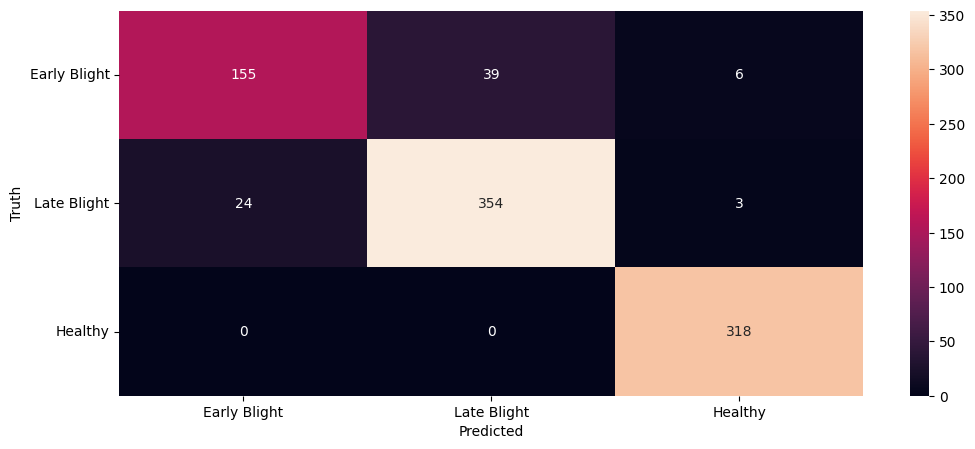

In [12]:
y_true_classes, y_pred_classes = model_preds(model1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [13]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.87      0.78      0.82       200
 Tomato_Late_blight       0.90      0.93      0.91       381
     Tomato_healthy       0.97      1.00      0.99       318

           accuracy                           0.92       899
          macro avg       0.91      0.90      0.91       899
       weighted avg       0.92      0.92      0.92       899



In [14]:
es = EarlyStopping(patience = 5)

model2 = Sequential()

model2.add(layers.Input(shape=(256,256,3)))
model2.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

# Dense Layers
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))

# Output
model2.add(Dense(3, activation='softmax'))

model2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model2.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 123ms/step - loss: 0.6800 - accuracy: 0.6812 - val_loss: 0.3193 - val_accuracy: 0.8521
Epoch 2/20
113/113 [==============================] - 15s 135ms/step - loss: 0.3103 - accuracy: 0.8698 - val_loss: 0.2645 - val_accuracy: 0.8854
Epoch 3/20
113/113 [==============================] - 14s 119ms/step - loss: 0.2294 - accuracy: 0.9072 - val_loss: 0.2461 - val_accuracy: 0.8932
Epoch 4/20
113/113 [==============================] - 13s 116ms/step - loss: 0.1538 - accuracy: 0.9464 - val_loss: 0.2289 - val_accuracy: 0.9010
Epoch 5/20
113/113 [==============================] - 14s 122ms/step - loss: 0.1237 - accuracy: 0.9550 - val_loss: 0.2354 - val_accuracy: 0.9166
Epoch 6/20
113/113 [==============================] - 13s 116ms/step - loss: 0.0502 - accuracy: 0.9825 - val_loss: 0.2376 - val_accuracy: 0.9299
Epoch 7/20
113/113 [==============================] - 14s 119ms/step - loss: 0.0347 - accuracy: 0.9917 - val_loss: 0.2351 - val_ac

Gets overfit so let's try some regularization.

In [15]:
es = EarlyStopping(patience = 5)

model3 = Sequential()

model3.add(layers.Input(shape=(256,256,3)))
model3.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())

# Dense Layers
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

# Output
model3.add(Dense(3, activation='softmax'))

model3.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model3.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 122ms/step - loss: 0.9690 - accuracy: 0.5096 - val_loss: 0.6675 - val_accuracy: 0.6785
Epoch 2/20
113/113 [==============================] - 13s 117ms/step - loss: 0.6218 - accuracy: 0.6920 - val_loss: 0.5270 - val_accuracy: 0.7219
Epoch 3/20
113/113 [==============================] - 13s 118ms/step - loss: 0.5310 - accuracy: 0.7387 - val_loss: 0.4053 - val_accuracy: 0.7920
Epoch 4/20
113/113 [==============================] - 14s 122ms/step - loss: 0.4648 - accuracy: 0.7587 - val_loss: 0.3836 - val_accuracy: 0.7998
Epoch 5/20
113/113 [==============================] - 14s 120ms/step - loss: 0.4134 - accuracy: 0.8039 - val_loss: 0.2922 - val_accuracy: 0.8665
Epoch 6/20
113/113 [==============================] - 13s 118ms/step - loss: 0.3553 - accuracy: 0.8412 - val_loss: 0.3263 - val_accuracy: 0.8487
Epoch 7/20
113/113 [==============================] - 13s 116ms/step - loss: 0.3086 - accuracy: 0.8748 - val_loss: 0.3184 - val_ac

Still over fitting a lot, let's add another dropout layer.

In [16]:
es = EarlyStopping(patience = 5)

model4 = Sequential()

model4.add(layers.Input(shape=(256,256,3)))
model4.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())

# Dense Layers
model4.add(Dense(32, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))

# Output
model4.add(Dense(3, activation='softmax'))

model4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model4.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 15s 119ms/step - loss: 1.0695 - accuracy: 0.4790 - val_loss: 0.9354 - val_accuracy: 0.6174
Epoch 2/20
113/113 [==============================] - 13s 113ms/step - loss: 0.7758 - accuracy: 0.7001 - val_loss: 0.9579 - val_accuracy: 0.5684
Epoch 3/20
113/113 [==============================] - 13s 114ms/step - loss: 0.6397 - accuracy: 0.7481 - val_loss: 0.6983 - val_accuracy: 0.7386
Epoch 4/20
113/113 [==============================] - 19s 168ms/step - loss: 0.5805 - accuracy: 0.7495 - val_loss: 0.4897 - val_accuracy: 0.7664
Epoch 5/20
113/113 [==============================] - 13s 115ms/step - loss: 0.5724 - accuracy: 0.7445 - val_loss: 0.4894 - val_accuracy: 0.7709
Epoch 6/20
113/113 [==============================] - 13s 116ms/step - loss: 0.5153 - accuracy: 0.7565 - val_loss: 0.4738 - val_accuracy: 0.7697
Epoch 7/20
113/113 [==============================] - 14s 121ms/step - loss: 0.5139 - accuracy: 0.7562 - val_loss: 0.4519 - val_ac

Still over fitting by a lot. Before trying another dropout layer, let's add in a l2 regularization, and see what the results are.

In [17]:
es = EarlyStopping(patience = 5)

model5 = Sequential()

model5.add(layers.Input(shape=(256,256,3)))
model5.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model5.add(Conv2D(64, (3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(64, (3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())

# Dense Layers
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dropout(0.5))
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dropout(0.5))

# Output
model5.add(Dense(3, activation='softmax'))

model5.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model5.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 121ms/step - loss: 1.4334 - accuracy: 0.5568 - val_loss: 0.8581 - val_accuracy: 0.7241
Epoch 2/20
113/113 [==============================] - 14s 121ms/step - loss: 0.9160 - accuracy: 0.6934 - val_loss: 0.7121 - val_accuracy: 0.7519
Epoch 3/20
113/113 [==============================] - 13s 119ms/step - loss: 0.7345 - accuracy: 0.7448 - val_loss: 0.5919 - val_accuracy: 0.7775
Epoch 4/20
113/113 [==============================] - 13s 115ms/step - loss: 0.6846 - accuracy: 0.7767 - val_loss: 0.8799 - val_accuracy: 0.7230
Epoch 5/20
113/113 [==============================] - 13s 117ms/step - loss: 0.6267 - accuracy: 0.8139 - val_loss: 0.5484 - val_accuracy: 0.8320
Epoch 6/20
113/113 [==============================] - 15s 128ms/step - loss: 0.5664 - accuracy: 0.8278 - val_loss: 0.5485 - val_accuracy: 0.8176
Epoch 7/20
113/113 [==============================] - 14s 122ms/step - loss: 0.5447 - accuracy: 0.8373 - val_loss: 0.5097 - val_ac

The model just so happened to start with a really low score, so it was able to hit 20 epochs, but in attempts to reproduce, the model would stil overfit and early stop.

In [18]:
es = EarlyStopping(patience = 5)

model6 = Sequential()

model6.add(layers.Input(shape=(256,256,3)))
model6.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model6.add(Conv2D(64, (3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Conv2D(64, (3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Flatten())

# Dense Layers
model6.add(Dense(16, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dropout(0.5))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dropout(0.5))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))

# Output
model6.add(Dense(3, activation='softmax'))

model6.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model6.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 120ms/step - loss: 1.5210 - accuracy: 0.4135 - val_loss: 1.3457 - val_accuracy: 0.4238
Epoch 2/20
113/113 [==============================] - 13s 118ms/step - loss: 1.2881 - accuracy: 0.4224 - val_loss: 1.2286 - val_accuracy: 0.4238
Epoch 3/20
113/113 [==============================] - 13s 118ms/step - loss: 1.2086 - accuracy: 0.4249 - val_loss: 1.1800 - val_accuracy: 0.4238
Epoch 4/20
113/113 [==============================] - 14s 120ms/step - loss: 1.1758 - accuracy: 0.4243 - val_loss: 1.1845 - val_accuracy: 0.4238
Epoch 5/20
113/113 [==============================] - 13s 117ms/step - loss: 1.1668 - accuracy: 0.4243 - val_loss: 1.1462 - val_accuracy: 0.4238
Epoch 6/20
113/113 [==============================] - 13s 116ms/step - loss: 1.1192 - accuracy: 0.4243 - val_loss: 1.1098 - val_accuracy: 0.4238
Epoch 7/20
113/113 [==============================] - 13s 119ms/step - loss: 1.1046 - accuracy: 0.4243 - val_loss: 1.1091 - val_ac

We've been tackling overfitting, but the accuracy on training is still worse than the validation of the original simple but overfit model. Adding more complexity hasn't really helped us that much. Let's start over, but now mess around with convolutions

In [19]:
es = EarlyStopping(patience = 5)

model7 = Sequential()

model7.add(layers.Input(shape=(256,256,3)))
model7.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model7.add(Conv2D(64, (4,4), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Conv2D(64, (4,4), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Flatten())

# Dense Layers
model7.add(Dense(64, activation='relu'))

# Output
model7.add(Dense(3, activation='softmax'))

model7.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model7.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 19s 135ms/step - loss: 1.1411 - accuracy: 0.5496 - val_loss: 1.0088 - val_accuracy: 0.5495
Epoch 2/20
113/113 [==============================] - 14s 124ms/step - loss: 0.9707 - accuracy: 0.5451 - val_loss: 0.8317 - val_accuracy: 0.6607
Epoch 3/20
113/113 [==============================] - 14s 120ms/step - loss: 0.7909 - accuracy: 0.6723 - val_loss: 0.8058 - val_accuracy: 0.6752
Epoch 4/20
113/113 [==============================] - 14s 121ms/step - loss: 0.5624 - accuracy: 0.7884 - val_loss: 0.6833 - val_accuracy: 0.7253
Epoch 5/20
113/113 [==============================] - 14s 121ms/step - loss: 0.4959 - accuracy: 0.7976 - val_loss: 0.7954 - val_accuracy: 0.7286
Epoch 6/20
113/113 [==============================] - 14s 122ms/step - loss: 0.3383 - accuracy: 0.8861 - val_loss: 0.7265 - val_accuracy: 0.7464
Epoch 7/20
113/113 [==============================] - 14s 121ms/step - loss: 0.2028 - accuracy: 0.9384 - val_loss: 0.8730 - val_ac

changing the convolution input matrix from 3 x 3 to 4 x 4 didn't have a great effect. Let's go back to 3 x 3 and instead see what happens if we add a conv layer and remove a conv layer.

In [20]:
es = EarlyStopping(patience = 5)

model8 = Sequential()

model8.add(layers.Input(shape=(256,256,3)))
model8.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Flatten())

# Dense Layers
model8.add(Dense(64, activation='relu'))

# Output
model8.add(Dense(3, activation='softmax'))

model8.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model8.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 120ms/step - loss: 0.7404 - accuracy: 0.6454 - val_loss: 0.3634 - val_accuracy: 0.8331
Epoch 2/20
113/113 [==============================] - 13s 119ms/step - loss: 0.3217 - accuracy: 0.8534 - val_loss: 0.3490 - val_accuracy: 0.8465
Epoch 3/20
113/113 [==============================] - 14s 119ms/step - loss: 0.3064 - accuracy: 0.8739 - val_loss: 0.4659 - val_accuracy: 0.8209
Epoch 4/20
113/113 [==============================] - 14s 125ms/step - loss: 0.2194 - accuracy: 0.9147 - val_loss: 0.1971 - val_accuracy: 0.9143
Epoch 5/20
113/113 [==============================] - 14s 120ms/step - loss: 0.1754 - accuracy: 0.9317 - val_loss: 0.1937 - val_accuracy: 0.9143
Epoch 6/20
113/113 [==============================] - 14s 120ms/step - loss: 0.1292 - accuracy: 0.9506 - val_loss: 0.1943 - val_accuracy: 0.9199
Epoch 7/20
113/113 [==============================] - 13s 118ms/step - loss: 0.0986 - accuracy: 0.9658 - val_loss: 0.1476 - val_ac

In [21]:
es = EarlyStopping(patience = 5)

model9 = Sequential()

model9.add(layers.Input(shape=(256,256,3)))
model9.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model9.add(Conv2D(64, (3,3), activation='relu'))
model9.add(MaxPooling2D(pool_size=(2,2)))

model9.add(Flatten())

# Dense Layers
model9.add(Dense(64, activation='relu'))

# Output
model9.add(Dense(3, activation='softmax'))

model9.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model9.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 17s 136ms/step - loss: 3.6017 - accuracy: 0.6754 - val_loss: 0.4043 - val_accuracy: 0.8420
Epoch 2/20
113/113 [==============================] - 13s 115ms/step - loss: 0.2823 - accuracy: 0.8942 - val_loss: 0.2558 - val_accuracy: 0.8932
Epoch 3/20
113/113 [==============================] - 13s 113ms/step - loss: 0.1104 - accuracy: 0.9670 - val_loss: 0.2362 - val_accuracy: 0.8999
Epoch 4/20
113/113 [==============================] - 13s 113ms/step - loss: 0.0413 - accuracy: 0.9897 - val_loss: 0.2254 - val_accuracy: 0.9155
Epoch 5/20
113/113 [==============================] - 13s 115ms/step - loss: 0.0210 - accuracy: 0.9956 - val_loss: 0.3152 - val_accuracy: 0.8966
Epoch 6/20
113/113 [==============================] - 13s 115ms/step - loss: 0.0068 - accuracy: 0.9992 - val_loss: 0.2654 - val_accuracy: 0.9210
Epoch 7/20
113/113 [==============================] - 13s 114ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2725 - val_ac

Looks like our training accuracy is much more overfit with less validation accuracy. Currently model 8 seems to have the best performance it has the highest accuracy (96% on training and 92% on validation accuracy) and is less over fit than other models. Our second best model was model 2 with a train accuracy of 99% and a validation accuracy of 92%.

Lets see how well they do with a confusion matrix, because of their similar accuacy scores it is most likely they are going to have similar misclassifiations.
___________________________

## Confusion matrixs

29/29 [==============================] - 4s 144ms/step


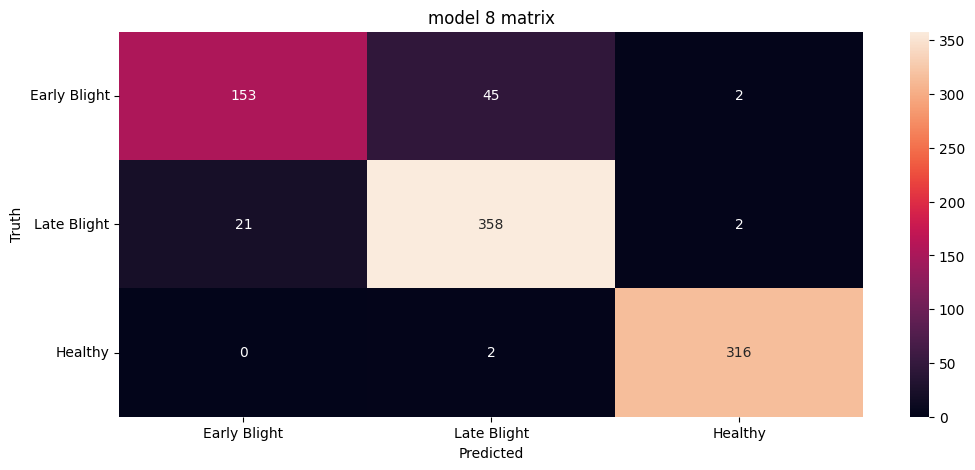

In [28]:
y_true_classes, y_pred_classes = model_preds(model8)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")
plt.title('model 8 matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('Model_8_Matrix.png')
plt.show()

In [23]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.88      0.77      0.82       200
 Tomato_Late_blight       0.88      0.94      0.91       381
     Tomato_healthy       0.99      0.99      0.99       318

           accuracy                           0.92       899
          macro avg       0.92      0.90      0.91       899
       weighted avg       0.92      0.92      0.92       899



29/29 [==============================] - 2s 76ms/step


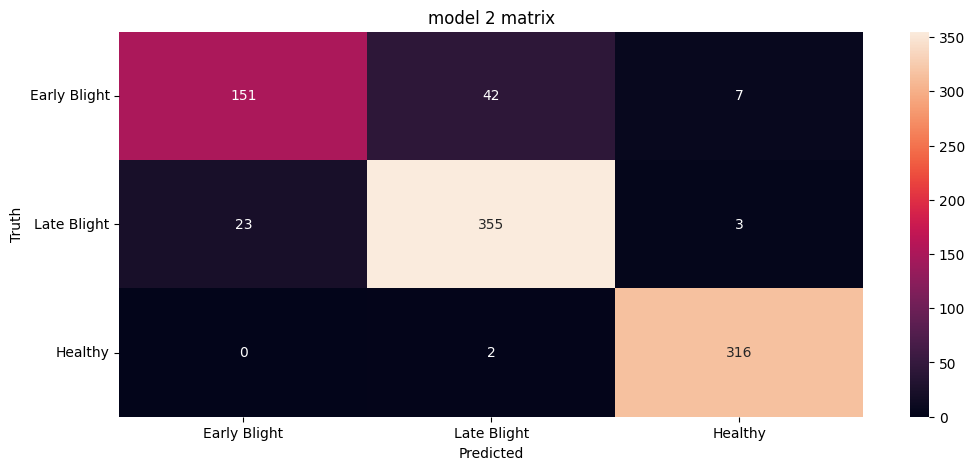

In [24]:
y_true_classes, y_pred_classes = model_preds(model2)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")
plt.title('model 2 matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [25]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.87      0.76      0.81       200
 Tomato_Late_blight       0.89      0.93      0.91       381
     Tomato_healthy       0.97      0.99      0.98       318

           accuracy                           0.91       899
          macro avg       0.91      0.89      0.90       899
       weighted avg       0.91      0.91      0.91       899



As expected since, they have similar accuracy scores we see they have similar classification rates. Lets just check a third model, in this case lets look at our most over fit model, model 9. Which has a training accuracy of 100%, but a validation accuracy of 90%.

29/29 [==============================] - 3s 88ms/step


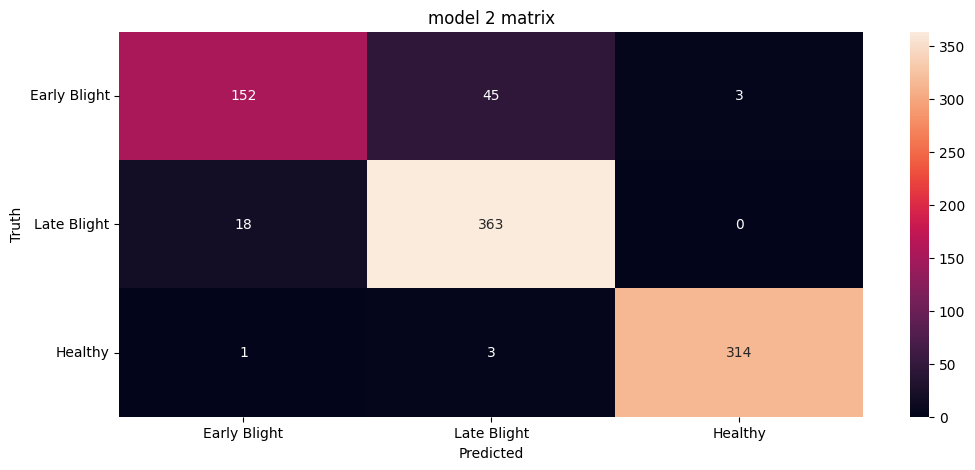

In [26]:
y_true_classes, y_pred_classes = model_preds(model9)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")
plt.title('model 2 matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [27]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.89      0.76      0.82       200
 Tomato_Late_blight       0.88      0.95      0.92       381
     Tomato_healthy       0.99      0.99      0.99       318

           accuracy                           0.92       899
          macro avg       0.92      0.90      0.91       899
       weighted avg       0.92      0.92      0.92       899



# Conclusion

Model 8 does pretty well on the accuracy score, but misclassifies a few blight plants as healthy which is something we dont want. Model 8 will beused due to being less overfit since the increase in validation accuracy is marginal. Because it has a low recall score on Early blight, that means we have a risk of missing the early stages of prevenative blight. Missclassifying a healthy plant as unhealthy is not as much of an issue since it would simply require a framer to check up on the plant.

The next goal is to improve the recall score of Early blight so farmers can intervenue before the disease spreads and effects other crops.